In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

shp = gpd.read_file("vejstoej_boliger_2022_udv/vejstoej_boliger_2022_udv.shp")
legeplads= gpd.read_file("legeplads/legeplads.shp")
daginstitutioner= gpd.read_file("daginstitutioner/daginstitutionerMPoint.shp")
grøn= gpd.read_file("park_groent_omr_oversigtskort/park_groent_omr_oversigtskort.shp") 

# Lokal fil
df_list_HC = pd.read_html("Aktuel luftkvalitet i Danmark.html")
df_list_jagtvej = pd.read_html("Aktuel luftkvalitet i Danmark jagtvej.html")
df_list_oersted = pd.read_html("Aktuel luftkvalitet i Danmark HCoersted.html")



In [26]:
grøn

,id,objekt_typ,kommune,geometry
0,23,Park,København,"POLYGON ((12.56527 55.70119, 12.56527 55.7012,..."
1,24,Park,København,"POLYGON ((12.56266 55.70289, 12.56261 55.70289..."
2,25,Park,København,"POLYGON ((12.56254 55.70235, 12.56329 55.70232..."
3,2608,Park,København,"POLYGON ((12.55274 55.67043, 12.5528 55.66998,..."
4,3144,Park,København,"POLYGON ((12.59233 55.64809, 12.59297 55.64811..."
...,...,...,...,...
1438,97,Park,København,"POLYGON ((12.53133 55.63794, 12.53129 55.63793..."
1439,651,Park,København,"POLYGON ((12.64381 55.6512, 12.6438 55.65117, ..."
1440,657,Park,København,"POLYGON ((12.64229 55.65103, 12.64062 55.65096..."
1441,655,Park,København,"POLYGON ((12.63538 55.66252, 12.63538 55.66251..."


In [73]:
def datetime(df_list):
    df= df_list[0]
    df["Målt (starttid)"] = pd.to_datetime(df["Målt (starttid)"], format="%d-%m-%Y %H:%M")
    df = df.sort_values("Målt (starttid)")
    df.set_index("Målt (starttid)", inplace=True)
    return df

df_HC=datetime(df_list_HC)
df_jagtvej=datetime(df_list_jagtvej)
df_oersted=datetime(df_list_oersted)


In [69]:
def plot_luftforurening(df):
    # Make sure datetime is the index
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex")

    # Get unique days for tick values (one per day)
    unique_days = df.index.normalize().unique()
    tickvals = unique_days
    ticktext = [d.strftime("%d-%b") for d in unique_days]

    # Only plot numeric columns
    numeric_cols = df.select_dtypes(include='number').columns

    # Plot
    fig = go.Figure()

    for col in numeric_cols:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[col],
            mode='lines',
            name=col
        ))

    fig.update_layout(
        title="Tidsserie af luftforurening på H. C. Andersens Boulevard",
        xaxis_title="Dato",
        yaxis_title="Koncentration (μg/m³ eller tilsvarende)",
        xaxis=dict(
            tickvals=tickvals,
            ticktext=ticktext,
            tickangle=45,
            showgrid=True
        ),
        yaxis=dict(showgrid=True),
        legend=dict(title="Stof"),
        template="plotly_white",
        height=600,
        width=1000
    )

    fig.show()


In [70]:
plot_luftforurening(df_HC)

In [71]:
plot_luftforurening(df_jagtvej)

In [74]:
plot_luftforurening(df_oersted)

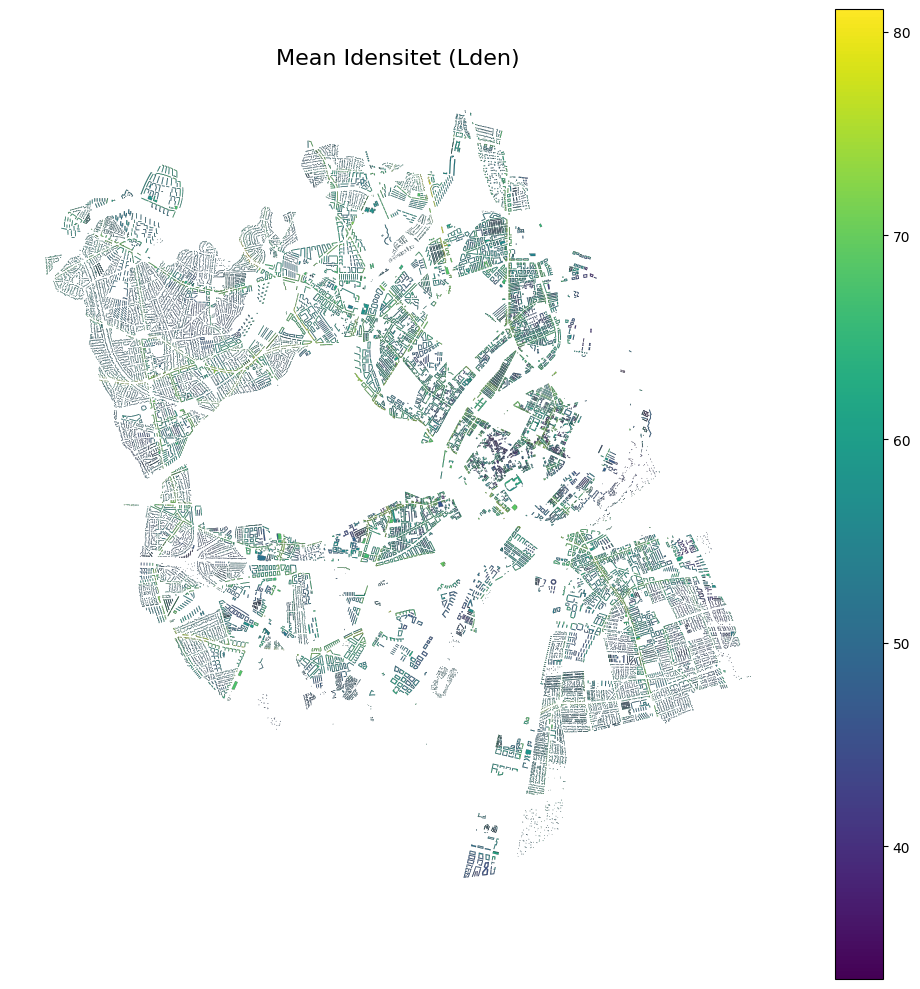

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
shp.plot(column='mean_lden',
         cmap='viridis',  # du kan også prøve 'plasma', 'coolwarm', osv.
         linewidth=0.1,
         edgecolor='black',
         legend=True,
         ax=ax)

ax.set_title("Mean Idensitet (Lden)", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import plotly.express as px

# Extract the first point from each geometry (assuming it's a MULTIPOINT with one coordinate)
legeplads['lon'] = legeplads.geometry.apply(lambda geom: geom.geoms[0].x)
legeplads['lat'] = legeplads.geometry.apply(lambda geom: geom.geoms[0].y)

# Create an interactive Plotly map
fig = px.scatter_mapbox(
    legeplads,
    lat='lat',
    lon='lon',
    hover_name='navn',  # Playground name
    hover_data=['adressebes', 'aldersgrup', 'graffitir0'],
    zoom=11,
    height=700
)
fig.update_traces(marker=dict(size=12))  # Try 12, 15, or higher for larger dots
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0}, title="Playgrounds in Copenhagen")

fig.show()
fig.write_image("playgrounds_map.png", scale=2)



In [24]:
import plotly.express as px

# Tæl antal institutioner pr. bydel
bydel_counts = daginstitutioner['bydel'].value_counts().reset_index()
bydel_counts.columns = ['City district', 'Number of institutions']

# Lav søjlediagram
fig = px.bar(bydel_counts,
             x='City district',
             y='Number of institutions',
             title='Number of institutions per city district in Copenhagen',
             labels={'City district': 'City district', 'Number of institutions': 'Number'},
             text='Number of institutions',
             height=700)

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_tickangle=-45)

fig.show()

# Gem som billede (kræver kaleido installeret)
fig.write_image("daginst.png", scale=2)


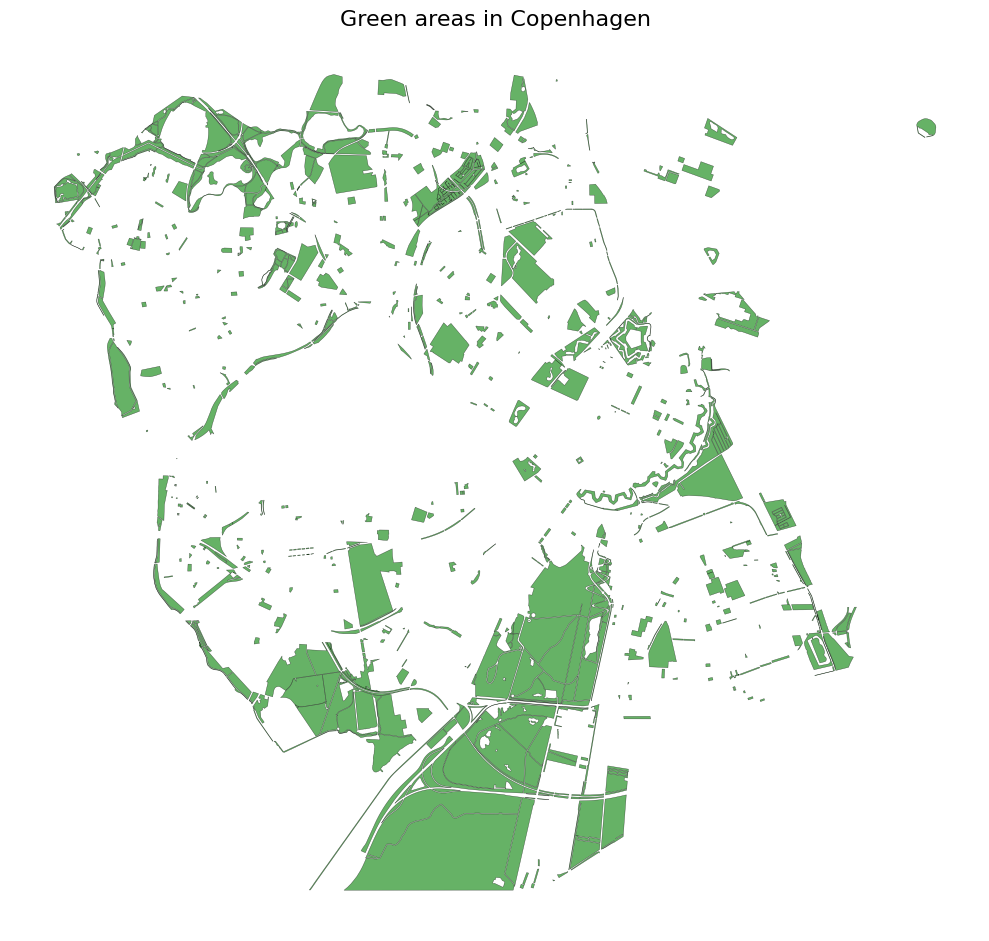

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Filtrér kun parker i Københavns Kommune (hvis ikke gjort)
grøn_kbh = grøn[grøn['kommune'] == 'København']

# Lav kort
fig, ax = plt.subplots(figsize=(10, 12))
grøn_kbh.plot(ax=ax, color='green', edgecolor='black', linewidth=0.3, alpha=0.6)

# Tilføj titel
ax.set_title('Green areas in Copenhagen', fontsize=16)

# Fjern akse
ax.set_axis_off()

plt.tight_layout()
plt.savefig('green_areas.png')
plt.show()

